In [98]:
# This is a test of the PyTorch library for neural networks

import torch
import numpy as np
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [99]:
# Loading in the MNIST dataset

# transforming pipeline
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
# loading the data
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=transform
)

testing_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=transform
)


In [100]:
print(len(training_data)) #The amount of samples in the dataset

#Note this is a tuple
#training_data[0]

#so we can access the label by 
image, label = training_data[0]  # Sample has 28x28 pixels
print(label) #this is the label for the data

image.shape #this is the shape of the image

60000
5


torch.Size([1, 28, 28])

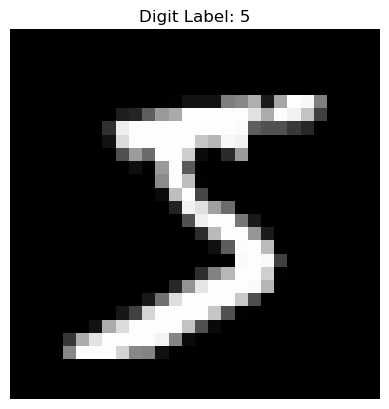

In [101]:
image, label = training_data[0]  # Sample has 28x28 pixels

# Display the image using matplotlib
plt.imshow(image.squeeze(), cmap='gray')  # Remove single channel with squeeze()
plt.title(f"Digit Label: {label}")
plt.axis('off')  # Turn off axis
plt.show()

### Batch Size: is the number of samples that we want to pass through the network at a time
### Epochs: is the number of times we want to pass through the entire dataset
### Learning Rate: is the step size for the gradient descent

In [102]:
# Note we are doing MLP (Multi Layer Perceptron) method and not CNN (Convolutional Neural Network)
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            #28*28 is the number of features which is all of the pixels inside of an image and this will be done for each image
            nn.Linear(in_features=28*28, out_features=20), #outfeatures is the neurons in the next layer that we want to have.
            nn.ReLU(), #relu is the activation function
            nn.Linear(20, 10),
            nn.Softmax(dim=1) #softmax to get the probability of each class between 0 and 1
        )
        # # Initialize weights after defining layers
        # # Get the first and second linear layers from Sequential
        # self.fc1 = self.linear_relu_stack[0]  # First Linear layer
        # self.fc2 = self.linear_relu_stack[2]  # Second Linear layer
        
        # # Initialize weights with proper scaling
        # nn.init.normal_(self.fc1.weight, mean=0, std=1/np.sqrt(784))
        # nn.init.normal_(self.fc2.weight, mean=0, std=1/np.sqrt(20))
        
        # # Zero initialization for biases
        # nn.init.zeros_(self.fc1.bias)
        # nn.init.zeros_(self.fc2.bias)

    def forward(self, x):
        #take in all the x features and pass it through the layers with all the rows.
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


In [103]:
#Note we have training_data and test_data, we will drop the last batch as it will mess with the encoding dimensions.
train_dataloader = DataLoader(training_data, batch_size=64, drop_last=True)
test_dataloader = DataLoader(testing_data, batch_size=64, drop_last=True)


# #Dataloader is a way to load the data in batches
# for batch in train_dataloader:
#     print(batch) #batches are in size of 64

for batch in train_dataloader:
    images, labels = batch
    print(images.shape)  # e.g., torch.Size([64, 1, 28, 28])
    print(labels.shape)  # e.g., torch.Size([64])
    break


#[64, 1, 28, 28]
#28x28 is the width and height
# 1 is the channel
#64 is the batch size, so we converted the data into 64 sized batches

#remember we ave batches and label
len(train_dataloader) #938 * 64 = 60032 last batch has less than 64 938 batches

torch.Size([64, 1, 28, 28])
torch.Size([64])


937

In [104]:
class TrainingData(Dataset):
    def __init__(self):
        #using mean squared error loss function similar to prev implementation
        self.lossfn = nn.MSELoss()

    def gradient_descent(self, model, dataloader, optimizer):
        ''' we are minimizing the loss function for each batch
        model: the NN model that we used to make a prediction
        optimizer: the optimizer that we used to update the weights
        train_dataloader: the dataloader that we used to load the data

        '''
        size = len(dataloader)

        # Enumeration step gets the index of the current batch (X,y) X is the tenor containing the input feature ie image and y is the label.
        for batch, (X, y) in enumerate(dataloader):
            # Doing one hot encoding for the labels
            # y_one_hot = torch.zeros(y.shape[0], 10)
            # y_one_hot.scatter_(1, labels.unsqueeze(1).long(), 1)


            prediction = model.forward(X)
            loss = self.lossfn(prediction, y)

            #Perform the backpropagation step for each layer in the model
            #Calculates all of the partial derivatives of the loss function with respect to the weights and biases
            loss.backward()

            optimizer.step()
            #prevents the gradient from accumulating
            optimizer.zero_grad()

            total = 1
            correct = 0
            #print(y.shape)
            _, predicted = torch.max(prediction.data, 1)
            #print(predicted.shape, "P")
            total += y.size(0)
            correct += (predicted == y).sum().item()

            if batch % 100 == 0:
                loss, current = loss.item(), batch * len(X)
                accuracy = 100 * correct / total
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
                print("accuracy: ", accuracy)



In [105]:
# Running the model and minizing the loss function using the gradient descent method with epochs
epochs = 10
learning_rate = 0.001

model = NeuralNetwork()
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
TrainingData = TrainingData()

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    TrainingData.gradient_descent(model, train_dataloader, optimizer)

print("Done!")

Epoch 1
-------------------------------


/opt/anaconda3/envs/PyTorch/lib/python3.11/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (10) must match the size of tensor b (64) at non-singleton dimension 1